<a href="https://colab.research.google.com/github/borislevant/cvplayground/blob/main/feature_detectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Feature Detectors
#### Excercising: Harris detector, etc.
##### Dr. Boris Levant, Dec 27, 2021



In [5]:
from scipy import signal as sig
import numpy as np
from skimage import data, io, color
from skimage.feature import corner_harris, corner_peaks

import matplotlib.pyplot as plt
from matplotlib import cm


Cloning into 'images1'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 30 (delta 1), reused 0 (delta 0), pack-reused 23
Unpacking objects: 100% (30/30), done.


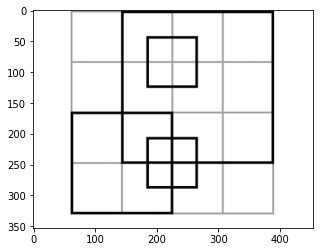

In [75]:
!git clone https://github.com/borislevant/documentscan/ images1
imgorig=io.imread('images1/checkboard.jpg')
img=color.rgb2gray(imgorig)
height, width = img.shape
plt.imshow(img, cmap='gray')

In [76]:
def gradient_x(imggray):
    ##Sobel operator kernels.
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    return sig.convolve2d(imggray, kernel_x, mode='same')
def gradient_y(imggray):
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    return sig.convolve2d(imggray, kernel_y, mode='same')

I_x = gradient_x(img)
I_y = gradient_y(img)

Ixx = I_x**2
Ixy = I_y*I_x
Iyy = I_y**2

In [100]:
k = 0.05

# determinant
detA = Ixx * Iyy - Ixy ** 2
# trace
traceA = Ixx + Iyy
    
harris_response = detA - k * traceA ** 2

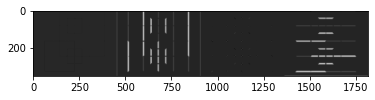

In [111]:
offset = 1
Sxx = np.zeros((height, width))
Sxy = np.zeros((height, width))
Syy = np.zeros((height, width))

for y in range(offset, height-offset):
    for x in range(offset, width-offset):
        Sxx[y, x] = np.sum(Ixx[y-offset:y+1+offset, x-offset:x+1+offset])
        Syy[y, x] = np.sum(Iyy[y-offset:y+1+offset, x-offset:x+1+offset])
        Sxy[y, x] = np.sum(Ixy[y-offset:y+1+offset, x-offset:x+1+offset])

det = (Sxx * Syy) - (Sxy**2)
trace = Sxx + Syy
harris_response = det - k*(trace**2)

plt.imshow(np.hstack([img, Sxx, Sxy, Syy]), cmap='gray')

k is the sensitivity factor to separate corners from edges, typically a value close to zero, for my analysis I have taken k=0.04. Small values of k result in detection of sharp corners. The response R is an array of peak values of each row in the image. We can use these peak values to isolate corners and edges as I will describe in the next step.

####Step 5: Find edges and corners using R
Edge : r < 0

Corner : r > 0

Flat: r = 0

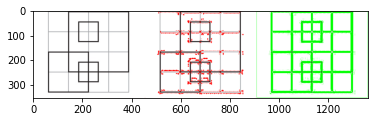

In [112]:
img_copy_for_corners = np.copy(imgorig)
img_copy_for_edges = np.copy(imgorig)

for rowindex, response in enumerate(harris_response):
    for colindex, r in enumerate(response):
        if r > 0:
            # this is a corner
            img_copy_for_corners[rowindex, colindex] = [255,0,0]
        elif r < 0:
            # this is an edge
            img_copy_for_edges[rowindex, colindex] = [0,255,0]

plt.imshow(np.hstack([imgorig, img_copy_for_corners, img_copy_for_edges]), cmap='gray')


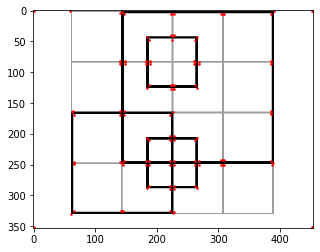

In [114]:
corners = corner_peaks(harris_response, min_distance=1, threshold_rel=0.03)
fig, ax = plt.subplots()
ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(corners[:, 1], corners[:, 0], '.r', markersize=3)